In [44]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import pyro
import pyro.distributions as dist
from pyro.infer import Predictive, NUTS, MCMC
import torch
import arviz as az

In [3]:
def process_data():

    data_path = "https://raw.githubusercontent.com/christophM/interpretable-ml-book/master/data/bike.csv"
    raw_data_df = pd.read_csv(data_path)
    df = raw_data_df.copy().assign(
        date=pd.date_range(
            start=pd.to_datetime('2011-01-01'),
            end=pd.to_datetime('2012-12-31'),
            freq='D'
        )
    )

    #print(df)

    def design_matrix(df):

        # prepare features
        df['cnt_scaled'] = (df['cnt'] - df['cnt'].mean()) / (df['cnt'].std())
        df['temp_scaled'] = (df['temp'] - df['temp'].mean()) / (df['temp'].std())
        df['hum_scaled'] = (df['hum'] - df['hum'].mean()) / (df['hum'].std())
        df['windspeed_scaled'] = (df['windspeed'] - df['windspeed'].mean()) / (df['windspeed'].std())

        df['holiday'] = df['holiday'].astype('category').cat.codes
        df['workingday'] = df['workingday'].astype('category').cat.codes
        df['weathersit'] = df['weathersit'].astype('category').cat.codes
        t = df['days_since_2011'].to_numpy() / df['days_since_2011'].max()
        
        X = {
            'cnt_scaled': torch.tensor(df['cnt_scaled'].values, dtype=torch.float32),
            'temp_scaled': torch.tensor(df['temp_scaled'].values, dtype=torch.float32),
            'hum_scaled': torch.tensor(df['hum_scaled'].values, dtype=torch.float32),
            'windspeed_scaled': torch.tensor(df['windspeed_scaled'].values, dtype=torch.float32),
            'workingday': torch.tensor(df['workingday'].values, dtype=torch.long),
            'weathersit': torch.tensor(df['weathersit'].values, dtype=torch.long),
            't': torch.tensor(t, dtype=torch.float32),
        }
    
        return X
    
    X = design_matrix(df)
    y = torch.tensor(df['cnt_scaled'].values)
    
    return X, y

In [4]:
def plot_prior_predictive(X, samples):

    prior_mean = torch.flatten(torch.mean(samples['likelihood'], 0, True))
    sns.lineplot(x=X['t'], y=prior_mean)
    plt.show()

In [62]:
def plot_posterior_predictive(X, y, samples):

    post_mean = samples.mean(axis=1).flatten()
    post_std = samples.std(axis=1).flatten()*2
    post_lower = (post_mean - post_std)
    post_upper = (post_mean + post_std)
    
    plt.figure(figsize=(14, 4))
    sns.lineplot(x=X['t'], y=y, linestyle='--')
    sns.lineplot(x=X['t'], y=post_mean, color='black')
    plt.fill_between(
        X['t'], post_lower, post_upper, 
        color='grey', alpha=0.5
    )

    plt.show()

In [90]:
def plot_varying_effect(X, coef):
    
    plt.figure(figsize=(10, 4))
    sns.scatterplot(
        x=X['temp_scaled'],
        y=coef
    )

In [32]:
X, y = process_data()

In [94]:
inf_vary = az.from_netcdf('./models/time_vary_coef')

<Figure size 1000x300 with 0 Axes>

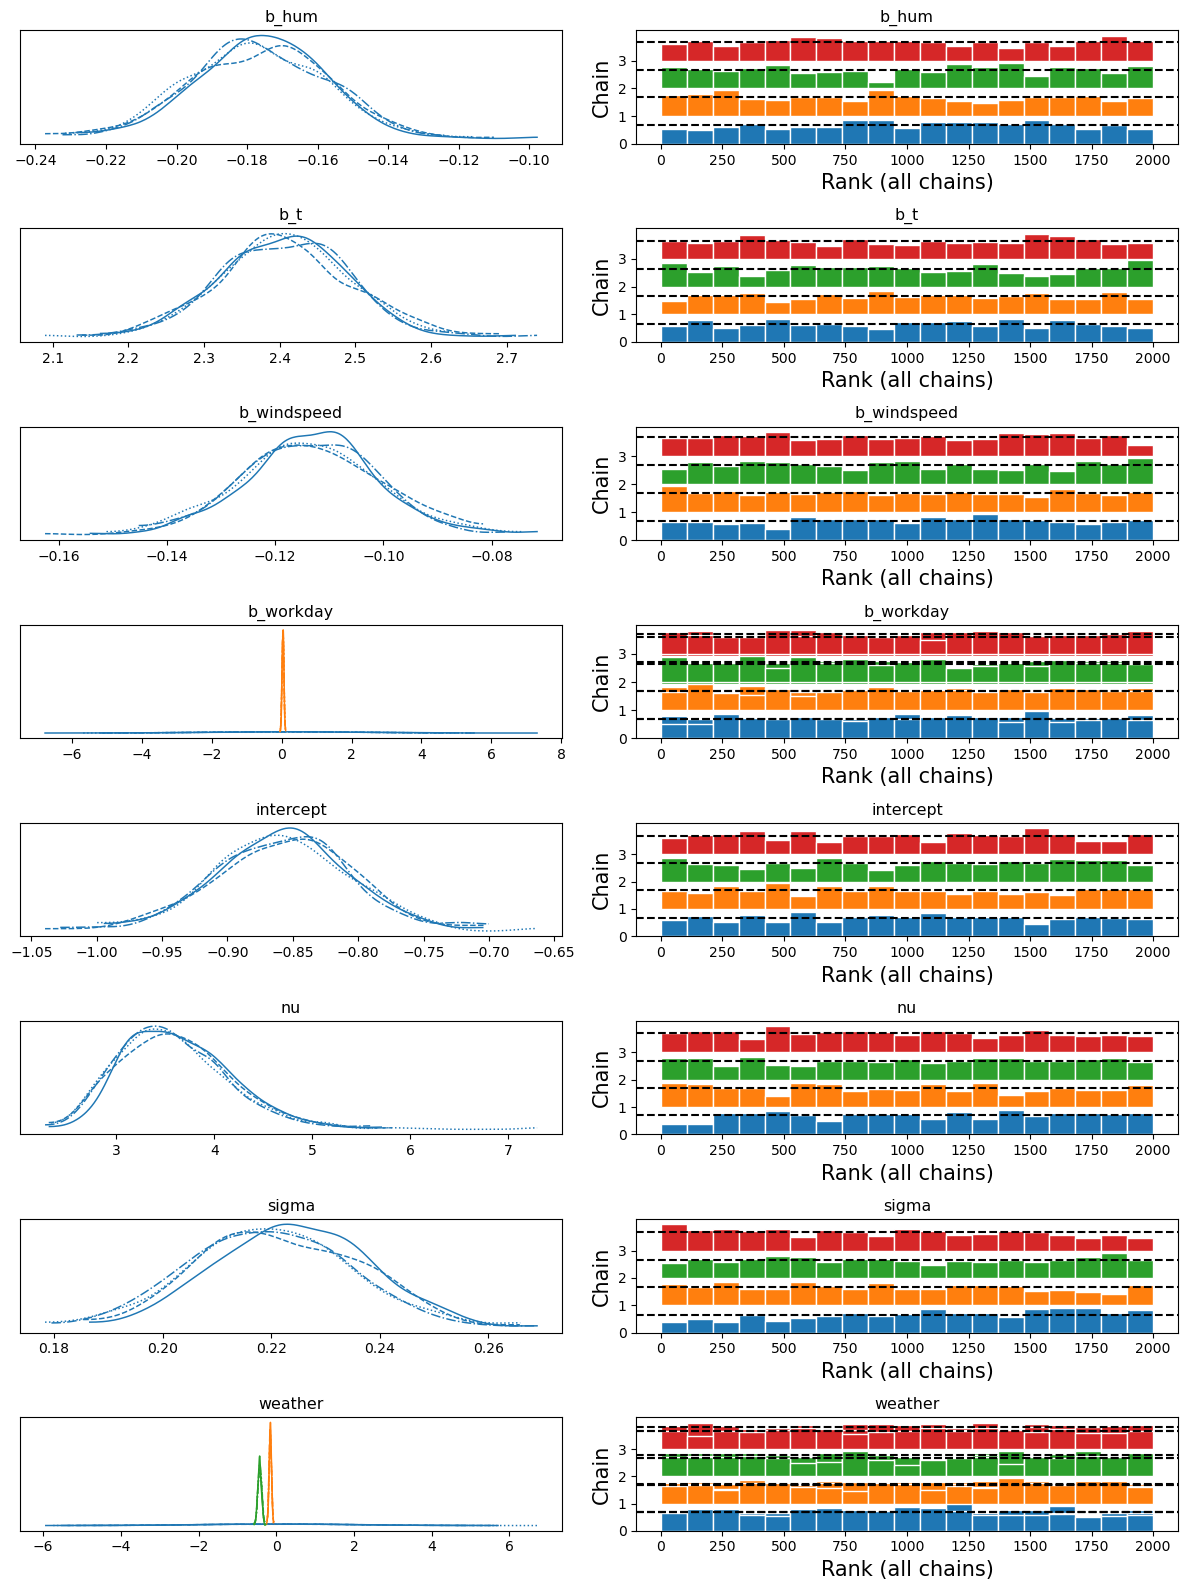

In [95]:
plt.figure(figsize=(10, 3))
az.plot_trace(
    data=inf_vary,
    kind='rank_bars',
    var_names=['~mu_dim_0', '~b_temp_rw', '~sigma_slope']
)
plt.tight_layout();

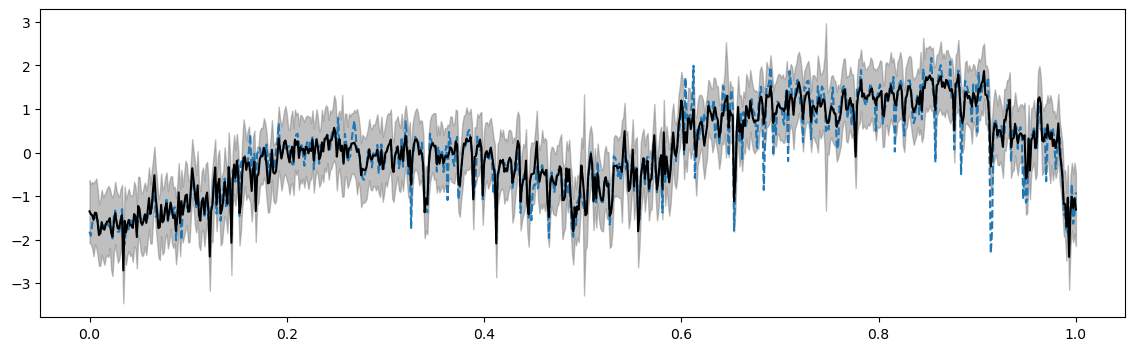

In [96]:
plot_posterior_predictive(X, y, inf_vary['posterior_predictive']['likelihood'].to_numpy())

In [97]:
temp_rw_slope = inf_vary['posterior']['b_temp_rw'].stack(sample=('chain', 'draw')).mean(axis=1).to_numpy()

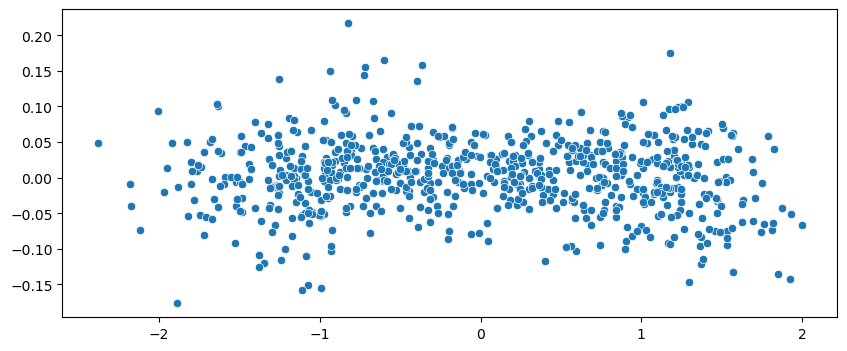

In [98]:
plot_varying_effect(X, temp_rw_slope)